<a href="https://colab.research.google.com/github/Soujanya-27/Story-and-Comic-Book-Generator/blob/main/Generate_Story_and_Comic_book_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Story and comic book writer, using Langchain, OpenAI (and Replica)</h1>

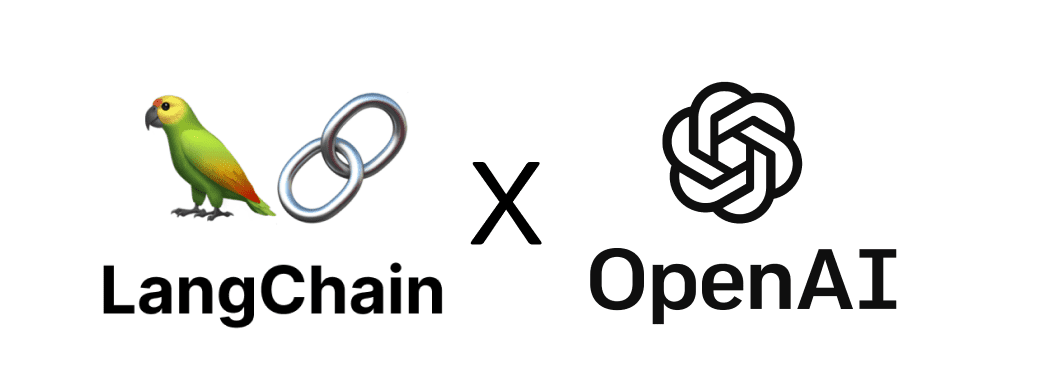

In [ ]:
!apt-get update
!apt-get install -y libreoffice
!pip install openai tiktoken langchain replicate kor python-docx unoconv

In [ ]:
import os

with open('/content/openai-api-key-demo2.txt', 'r') as fp:
  openai_api_key = fp.read()


with open('/content/replicate-ai-default-key.txt', 'r') as fp2:
  rep_api_key = fp2.read()

os.environ["REPLICATE_API_TOKEN"] = rep_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key
os.environ["OPENAI_ORGANIZATION"] = "org-lKHvypYFEpX1fu0oHg0wLGnb"
# del os.environ["OPENAI_ORGANIZATION"]

In [ ]:
from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO
import cv2
from google.colab.patches import cv2_imshow

from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT

import subprocess

from langchain import PromptTemplate, LLMChain
from langchain.llms import Replicate, OpenAI

In [ ]:
pip install langchain-community

In [ ]:
template = """Write a short story about {topic}.
First generate a title for the story and a cover picture. Make the story in a narrative format.
Divide it into 5 chapters. Limit each chapter to 200 words. Also generate a prompt for an image generation model at the end of each chapter.
Always generate the output in following format:

Title: Main title of the story
Cover Image: Prompt for image generation model
Chapter 1:
Title: Title of chapter 1
Text: Story text of chapter 1
Image Prompt: Prompt for image generation model
Chapter 2:
Title: Title of chapter 2
Text: Story text of chapter 2
Image Prompt: Prompt for image generation model
Chapter n:
Title: Title of chapter n
Text: Story text of chapter n
Image Prompt: Prompt for image generation model
"""

prompt = PromptTemplate(template=(template), input_variables=["topic"])

In [ ]:
llm = OpenAI(temperature=0.7, model="gpt-3.5-turbo-instruct", max_tokens=2000)
llm_chain = LLMChain(prompt=prompt, llm=llm)

In [ ]:
## ENTER YOUR TOPIC HERE
topic_text = input()

result = llm_chain.run(
    topic_text
)

In [ ]:
result

In [ ]:
with open("story.txt", 'w+') as file:
    file.write(result)

In [ ]:
with open('story.txt', 'r') as file:
    lines = file.readlines()

story = {}
is_chapter = False

chapters = []
chapter_dict = {}

for line in lines:



    line_sm = line.lower().strip()

    if 'title' in line_sm and not is_chapter:
        story['title'] = line.split(':')[-1].strip()

    if 'title' in line_sm and is_chapter:
        chapter_dict['title'] = line.split(':')[-1].strip()

    if 'cover image' in line_sm:
        story['cover_image'] = line.split(':')[-1].strip()

    if 'text' in line_sm:
        chapter_dict['text'] = line.split(':')[-1].strip()

    if 'image prompt' in line_sm:
        chapter_dict['image_prompt'] = line.split(':')[-1].strip()
        chapters.append(chapter_dict)

    if 'chapter' in line_sm:
        is_chapter = True
        chapter_dict = {}
        continue

story['chapters'] = chapters
story

In [ ]:
text2image = Replicate(
    model="stability-ai/stable-diffusion:db21e45d3f7023abc2a46ee38a23973f6dce16bb082a930b0c49861f96d1e5bf",
    inputs={"image_dimensions": "512x512"},
)

In [ ]:
style_prompts = " Graphic Novel, 4K, Global Illumination, Dreamy"

In [ ]:
img_path = './images/'

if not os.path.exists(img_path):
    os.makedirs(img_path)

generated_images_dict = {}
image_prompts_dict = story
print(image_prompts_dict)
cover_image_prompt = image_prompts_dict["cover_image"]


# style of image
cover_image_prompt += style_prompts

# execute image generation pipeline
image_output = text2image(cover_image_prompt)

response = requests.get(image_output)
image_output = Image.open(BytesIO(response.content))

cover_path = os.path.join(img_path, 'cover_image.jpg')
image_output.save(cover_path)

generated_images_dict["cover_image"] = cover_path

chapter_images = []
for idx, chapter_image_prompts in tqdm(enumerate(image_prompts_dict['chapters'])):
    chapter_image_prompts = chapter_image_prompts['image_prompt']
    chapter_image_prompts += style_prompts
    image_output = text2image(chapter_image_prompts)
    response = requests.get(image_output)
    image_output = Image.open(BytesIO(response.content))
    chapter_path = os.path.join(img_path, f'chapter_{idx+1}.jpg')
    image_output.save(chapter_path)
    chapter_images.append(chapter_path)

generated_images_dict["chapter_images"] = chapter_images
generated_images_dict
{'cover_image': './images/cover_image.jpg',
 'chapter_images': ['./images/chapter_1.jpg',
  './images/chapter_2.jpg',
  './images/chapter_3.jpg',
  './images/chapter_4.jpg',
  './images/chapter_5.jpg']}